# Age Classification of *Chen Pi* with ResNet50

Images are taken manually.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision.io import read_image
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import numpy as np
import pandas as pd
import random
import os
import json

In [2]:
IMG_DIR = "./data_orange_peels/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 0.001
IMAGE_SIZE = (3024, 4032)
SIZE_MODIFIER = 0.1875
RESNET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
RESNET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [3]:
encoder = {
    6 : 0,
    10 : 1,
    15 : 2,
    20 : 3,
}

decoder = { v:k for k,v in encoder.items()}

class OrangePeelsDataset(Dataset):
    def __init__(self, img_dir, class_size = None, transform = None, target_transform = None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        # for subdir in os.listdir(img_dir):
        #     for file in os.listdir(os.path.join(img_dir, subdir)):
        #         if file.startswith("IMG"):
        #             data["image_path"].append(os.path.join(img_dir, subdir, file))
        #             data["label"].append(int(subdir))
        
        for subdir in os.listdir(img_dir):
            files = [f for f in os.listdir(os.path.join(img_dir, subdir)) if f.startswith("IMG")]
            random.shuffle(files)
            for idx, file in enumerate(files):
                if class_size is not None:
                    if idx >= class_size:
                        break

                data["image_path"].append(os.path.join(img_dir, subdir, file))
                data["label"].append(int(subdir))

        self.annotations = pd.DataFrame(data).sample(frac = 1).reset_index(drop = True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [4]:
def create_model(base_model, optimizer, num_classes = 4, device = None, learning_rate = LR):
    # extract all but last layers from base model
    feature_extractor = nn.Sequential(*list(deepcopy(base_model).children())[:-1])
    
    # freeze feature extractor
    for param in feature_extractor.parameters():
        param.requires_grad = False
    
    # create new classifier with one linear layer
    model = nn.Sequential(
        feature_extractor,
        nn.Flatten(),
        nn.Linear(2048, num_classes)
    )

    if device is not None:
        model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = learning_rate)

    return model, optimizer

def train_model(model, train_loader, test_loader, optimizer, criterion, device = None, epochs = NUM_EPOCHS, stats = False):
    losses = []
    accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            accuracies.append((outputs.argmax(1) == labels).float().mean().item()) # running accuracy

        if stats:
            print(f"Epoch {epoch + 1} / {epochs} : Loss = {losses[-1]:.4f}, Accuracy = {accuracies[-1]:.4f}")

        # testing accuracy   
        model.eval()
        predictions, true = test_model(model, test_loader, device)
        test_accuracies.append((predictions == true).float().mean().item())

    return losses, accuracies, test_accuracies

def test_model(model, loader, device = None):
    predictions = torch.tensor([], dtype = torch.long).to(device)
    true = torch.tensor([], dtype = torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions = torch.cat((predictions, predicted))
            true = torch.cat((true, labels))

    return predictions, true

def get_average_auc(predict, actual, num_classes = 4):
    aucs = []
    for i in range(num_classes):
        i_predict = predict == i
        i_actual = actual == i
        aucs.append(metrics.roc_auc_score(i_actual, i_predict))

    return np.mean(aucs), aucs

In [5]:
transform = transforms.Compose([
    transforms.Resize((int(SIZE_MODIFIER*IMAGE_SIZE[0]), int(SIZE_MODIFIER*IMAGE_SIZE[1]))),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD),
    # transforms.RandomRotation(30),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in RESNET_STD]),
    transforms.Normalize(mean = [-m for m in RESNET_MEAN], std = [1., 1., 1.]),
])

data = OrangePeelsDataset(IMG_DIR, class_size = 80, transform = transform)
print("Length:", len(data))

train, test = random_split(
    data,
    [
        int(0.8*len(data)),
        len(data) - int(0.8*len(data))
    ]
)

train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

Length: 320


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Shape: (567, 756, 3) (0.1875)


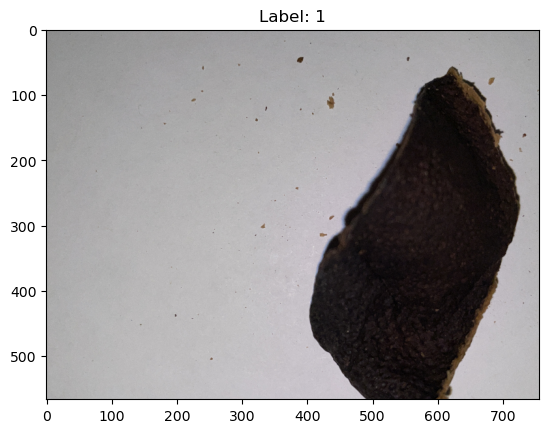

In [7]:
image = inverse_transform(data[random.randint(0, len(data))][0]).numpy().astype(np.int32).transpose(1, 2, 0)
plt.imshow(image)
plt.title(f"Label: {data[0][1]}")
print(f"Shape: {image.shape} ({SIZE_MODIFIER})")

In [8]:
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
d = {}
skf = KFold(n_splits = 5, shuffle = True, random_state = 42)
for i, (train_idx, test_idx) in enumerate(skf.split(data.annotations["image_path"], data.annotations["label"])):
    key = f"fold_{i}"
    d[key] = {}

    train = Subset(data, train_idx)
    test = Subset(data, test_idx)
    train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
    test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

    optimizer = torch.optim.Adam
    model, optimizer = create_model(resnet50, optimizer, device = device)
    criterion = nn.CrossEntropyLoss()
    losses, accuracies, test_accuracies = train_model(
        model,
        train_loader,
        test_loader,
        optimizer,
        criterion,
        device = device,
        stats = True
    )
    predictions, true = test_model(model, test_loader, device = device)
    auc = get_average_auc(predictions.cpu().numpy(), true.cpu().numpy())

    d[key]["model"] = model
    d[key]["losses"] = losses
    d[key]["accuracies"] = accuracies
    d[key]["test_accuracies"] = test_accuracies
    d[key]["predictions"] = predictions
    d[key]["true"] = true
    d[key]["auc"] = auc
    d[key]["accuracy"] = metrics.accuracy_score(true.cpu().numpy(), predictions.cpu().numpy())

Epoch 1 / 20 : Loss = 1.3527, Accuracy = 0.4375
Epoch 2 / 20 : Loss = 1.2670, Accuracy = 0.3125
Epoch 3 / 20 : Loss = 1.1916, Accuracy = 0.6250
Epoch 4 / 20 : Loss = 1.0627, Accuracy = 0.7188
Epoch 5 / 20 : Loss = 1.1174, Accuracy = 0.6875
Epoch 6 / 20 : Loss = 1.0209, Accuracy = 0.6562
Epoch 7 / 20 : Loss = 0.8400, Accuracy = 0.8438
Epoch 8 / 20 : Loss = 0.8155, Accuracy = 0.8125
Epoch 9 / 20 : Loss = 0.9070, Accuracy = 0.8125
Epoch 10 / 20 : Loss = 0.9935, Accuracy = 0.6250
Epoch 11 / 20 : Loss = 0.7667, Accuracy = 0.7812
Epoch 12 / 20 : Loss = 0.7212, Accuracy = 0.8750
Epoch 13 / 20 : Loss = 0.7020, Accuracy = 0.9062
Epoch 14 / 20 : Loss = 0.6515, Accuracy = 0.8438
Epoch 15 / 20 : Loss = 0.6600, Accuracy = 0.8438
Epoch 16 / 20 : Loss = 0.6154, Accuracy = 0.8750
Epoch 17 / 20 : Loss = 0.7733, Accuracy = 0.7812
Epoch 18 / 20 : Loss = 0.7880, Accuracy = 0.7500
Epoch 19 / 20 : Loss = 0.7997, Accuracy = 0.6250
Epoch 20 / 20 : Loss = 0.5677, Accuracy = 0.8750
Epoch 1 / 20 : Loss = 1.4699,

In [10]:
print("Folds:", list(d.keys()))
print("Fold Keys:", list(d["fold_0"].keys()))

Folds: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
Fold Keys: ['model', 'losses', 'accuracies', 'test_accuracies', 'predictions', 'true', 'auc', 'accuracy']


In [11]:
print("Average Accuracy:", np.mean([d[key]["accuracy"] for key in d.keys()]))

Average Accuracy: 0.796875


In [12]:
np.array([(key, d[key]["accuracy"]) for key in d.keys()])

array([['fold_0', '0.78125'],
       ['fold_1', '0.84375'],
       ['fold_2', '0.8125'],
       ['fold_3', '0.78125'],
       ['fold_4', '0.765625']], dtype='<U32')

Fold Accuracy: 0.78125


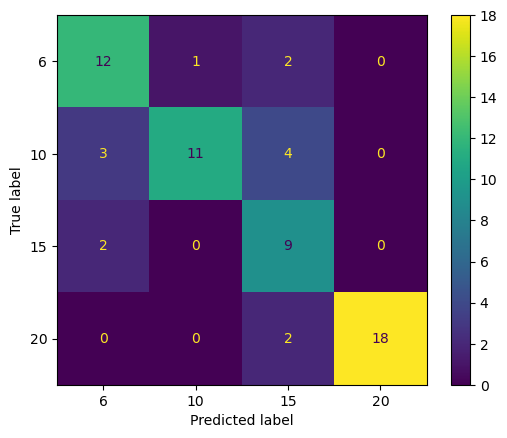

In [13]:
key = "fold_0"
matrix = metrics.ConfusionMatrixDisplay.from_predictions(
    d[key]["true"].cpu().numpy(),
    d[key]["predictions"].cpu().numpy(),
    display_labels = [6, 10, 15, 20]
)
print("Fold Accuracy:", metrics.accuracy_score(d[key]["true"].cpu().numpy(), d[key]["predictions"].cpu().numpy()))

In [50]:
auc_scores = {}
for key in d.keys():
    print(f"{key}:")
    for i in range(4):
        label_trues = d[key]["true"].cpu().numpy() == i
        label_predicts = d[key]["predictions"].cpu().numpy() == i
        auc_score = metrics.roc_auc_score(label_trues, label_predicts)
        print(f"\tLabel {decoder[i]} ({i}): {auc_score}")
        if i not in auc_scores:
            auc_scores[i] = []
        auc_scores[i].append(auc_score)
for key in auc_scores:
    print(f"{decoder[key]}: {np.mean(auc_scores[key])}")

fold_0:
	Label 6 (0): 0.8444444444444443
	Label 10 (1): 0.7076023391812865
	Label 15 (2): 0.7813852813852813
	Label 20 (3): 0.7390648567119156
fold_1:
	Label 6 (0): 0.7360544217687074
	Label 10 (1): 0.7947434292866082
	Label 15 (2): 0.711514392991239
	Label 20 (3): 0.7925170068027211
fold_2:
	Label 6 (0): 0.8020833333333334
	Label 10 (1): 0.7108843537414965
	Label 15 (2): 0.59375
	Label 20 (3): 0.8879849812265331
fold_3:
	Label 6 (0): 0.7489795918367348
	Label 10 (1): 0.7057142857142856
	Label 15 (2): 0.5729166666666666
	Label 20 (3): 0.6175438596491228
fold_4:
	Label 6 (0): 0.825
	Label 10 (1): 0.6693877551020408
	Label 15 (2): 0.8171717171717171
	Label 20 (3): 0.8020833333333333
6: 0.791312358276644
10: 0.7176664326051435
15: 0.6953476116429809
20: 0.7678388075447252


In [63]:
for key in d.keys():
    print(f"{key}")
    print(metrics.classification_report(
        d[key]["true"].cpu().numpy(),
        d[key]["predictions"].cpu().numpy(),
    ))
    print()

fold_0
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        10
           1       0.67      0.53      0.59        19
           2       0.75      0.68      0.71        22
           3       0.53      0.62      0.57        13

    accuracy                           0.64        64
   macro avg       0.63      0.66      0.64        64
weighted avg       0.65      0.64      0.64        64


fold_1
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.56      0.82      0.67        17
           2       0.64      0.53      0.58        17
           3       0.71      0.67      0.69        15

    accuracy                           0.64        64
   macro avg       0.66      0.64      0.64        64
weighted avg       0.66      0.64      0.64        64


fold_2
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        1

Image Number: 29


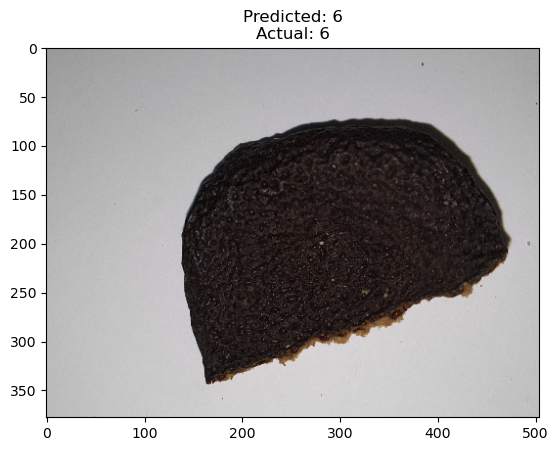

In [14]:
idx = np.random.randint(0, len(test))
sample_image = test[idx][0]
sample_label = test[idx][1]
print("Image Number:", idx)

with torch.no_grad():
    model = d["fold_0"]["model"].to(device)
    sample_predict = model(sample_image[None, :, :, :].to(device))
    _, sample_predict = torch.max(sample_predict.data, 1)

plt.imshow(inverse_transform(sample_image).numpy().astype(np.int32).transpose(1, 2, 0))
plt.title("Predicted: {}\nActual: {}".format(decoder[sample_predict.item()], decoder[sample_label]))
plt.show()

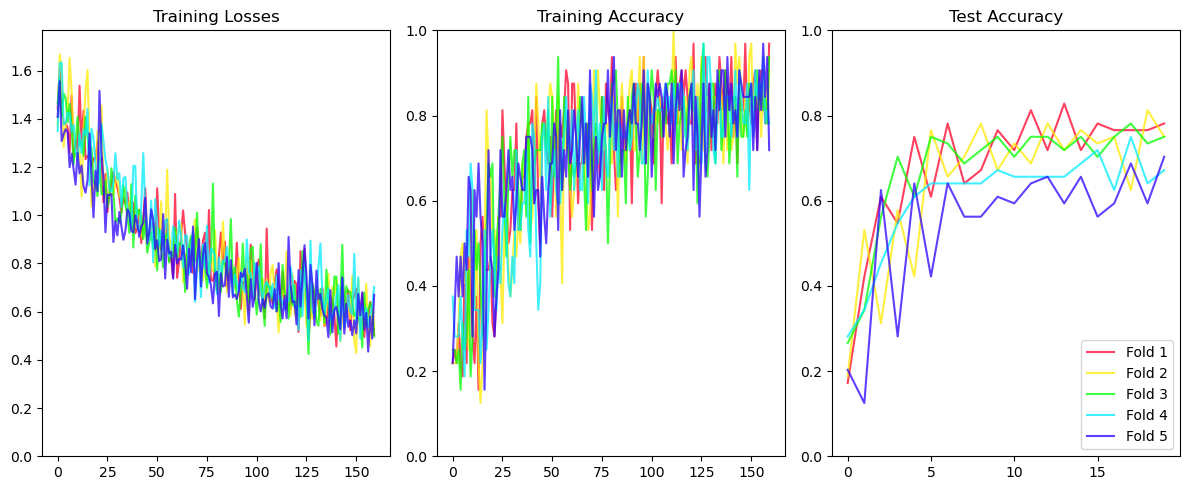

In [18]:
cmap = plt.get_cmap("gist_rainbow")
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
max_loss = -1
for i, k in enumerate(d.keys()):
    label = f"Fold {int(k.split('_')[1])+1}"
    color = cmap(i/len(d.keys()))
    if max(d[k]["losses"]) > max_loss:
        max_loss = max(d[k]["losses"])
    axes[0].plot(d[k]["losses"], label=label, color=color, alpha=0.75)
    axes[1].plot(d[k]["accuracies"], label=label, color=color, alpha=0.75)
    axes[2].plot(d[k]["test_accuracies"], label=label, color=color, alpha=0.75)
axes[0].set_ylim([0, max_loss + 0.1])
axes[0].set_title("Training Losses")
axes[1].set_ylim([0, 1])
axes[1].set_title("Training Accuracy")
axes[2].set_ylim([0, 1])
axes[2].set_title("Test Accuracy")
plt.tight_layout()
plt.legend()
plt.show()

In [19]:
torch.save(d["fold_0"]["model"], "frozen_0_781_model.pt")